# project 2 #

### Part 1. Building the TF-IDF matrix. ###

In [0]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from matplotlib import mlab as mlab

import numpy as np
np.random.seed(42)
import random
random.seed(42)

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']
cluster_dataset = fetch_20newsgroups(subset = 'all', categories = categories, shuffle = True, random_state = 42)
#print(cluster_dataset.target_names)

In [0]:
# Defined stopwords
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords') #uncomm if 1st time run

stop_words_en = stopwords.words('english')

#print("# of stop_words_skt:\t\t %s" % len(stop_words_skt))
#print("# of stop_words_en:\t\t %s" % len(stop_words_en))

from string import punctuation
#print("# of punctuation:\t\t %s" % len(punctuation))
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
#print(combined_stopwords)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()
def stem_rmv_punc(doc):
    return (word for word in analyzer(doc) if word.isalpha() and word not in combined_stopwords)

# tfidf set min_df3, remove stop words, post_train_dataset = cluster_dataset after processer
count_vectorizer = CountVectorizer(min_df = 3, max_df = 0.9, stop_words = 'english',analyzer = stem_rmv_punc)
cluster_counts = count_vectorizer.fit_transform(cluster_dataset.data)
#print(count_vectorizer.get_feature_names())

#### Question 1: Report the dimensions of the TF-IDF matrix you get

In [0]:
# tfidf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

cluster_tfidf = tfidf_transformer.fit_transform(cluster_counts)
print('Dimensions of the TF-IDF Matirx: ', cluster_tfidf.shape)

Dimensions of the TF-IDF Matirx:  (7882, 22025)


In [0]:
# convert dataset.target into binary, in which comp is 0 and rec is 1
# for issues of "multiclass format error"
vfunc = np.vectorize(lambda t : int(t / 4))
bi_cluster_dataset_target = vfunc(cluster_dataset.target)

### Part 2. Apply K-means clustering ###

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from matplotlib.cm import get_cmap
import itertools

k = 2
k_mean = KMeans(n_clusters = k, n_jobs = -1, random_state =0, max_iter = 1000, n_init = 30)
k_mean.fit(cluster_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=30, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [0]:
def plot_confusion_matrix(target, labels, normalize=False):
    """
    This function geives credit to : website
    "http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html"
    """
    cm = metrics.confusion_matrix(target, labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="gray")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
 

#### Question 2: Report the contingency table of your clustering result

Confusion matrix, without normalization


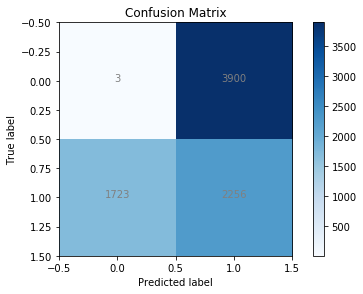

In [0]:
plot_confusion_matrix(bi_cluster_dataset_target, k_mean.labels_)

#### Question 3: Report the 5 measures above for the K-mean clustering results you get

In [0]:
print("Homogeneity: %0.8f" % 
      metrics.homogeneity_score(bi_cluster_dataset_target, k_mean.labels_))
print("Completeness: %0.8f" % 
      metrics.completeness_score(bi_cluster_dataset_target, k_mean.labels_))
print("V-measure: %0.8f" % 
      metrics.v_measure_score(bi_cluster_dataset_target, k_mean.labels_))
print("Adjusted Rand-Index: %0.8f" % 
      metrics.adjusted_rand_score(bi_cluster_dataset_target, k_mean.labels_))
print("Adjusted Mutual Information Score: %0.8f" % 
      metrics.adjusted_mutual_info_score(bi_cluster_dataset_target, k_mean.labels_))

Homogeneity: 0.25556390
Completeness: 0.33699931
V-measure: 0.29068581
Adjusted Rand-Index: 0.18205915
Adjusted Mutual Information Score: 0.25549574


E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


### Part 3. Dimensionality reduction ###

#### Question 4: Report the plot of the percent of variance the top r principle components can retain v.s r.

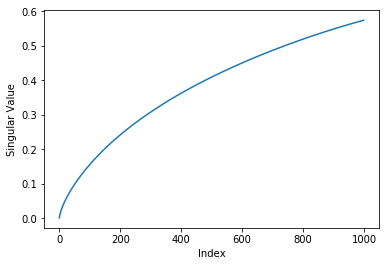

In [0]:
from sklearn.decomposition import TruncatedSVD

# Reduce dimension to 1000
svd = TruncatedSVD(n_components = 1000, random_state = 42)
cluster_svd = svd.fit_transform(cluster_tfidf)

variance = np.cumsum(svd.explained_variance_ratio_)
#print(variance)

plt.plot(variance)
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.show()

In [0]:
print(cluster_svd.shape)
print(bi_cluster_dataset_target.shape)

(7882, 1000)
(7882,)


#### Question 5: Report the best r choice for SVD and NMF respectively

In [0]:
def print_measures_and_plot_scores( r_value,scores,title):
    # Formating measures and print out
    homogeneity = [ round(element,8) for element in scores[0]]
    completeness = [ round(element,8) for element in scores[1]]
    v_measure = [ round(element,8) for element in scores[2]]
    adjusted_rand = [ round(element,8) for element in scores[3]]
    adjusted_mutual_info= [ round(element,8) for element in scores[4]]
    
    print('Report for {} Measures and Plot'.format(title))
    print('\nHomogeneity:\t{}\nCompleteness:\t{}\nV_measure:\t{}\nAdj rand Idx:\t{}\nAdj Mut Info:\t{}'.format(
    homogeneity,completeness,v_measure,adjusted_rand,adjusted_mutual_info))
    
    # Get best r and print out
    best_r = r[np.argmax(np.sum(scores,axis=0))]
    print('\nBest r value:\t',best_r)
    
    # plot
    legend = ['Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand', 'Adjusted Mutual Info']
    x_new = [str(i) for i in r]
    for i in range(5):
        plt.plot(x_new,scores[i],label=legend[i])
    plt.ylabel('Performance Metrics')
    plt.xlabel('Parameter Value')
    plt.show()


In [0]:
r = [1,2,3,5,10,20,50,100,300]

In [0]:
# Truncated SVD 
svd_scores = [[],[],[],[],[]]
for i in r:
    # Reduce dimension to r
    k_mean.fit(cluster_svd[:,:i])
    svd_scores[0].append(metrics.homogeneity_score(bi_cluster_dataset_target, k_mean.labels_))
    svd_scores[1].append(metrics.completeness_score(bi_cluster_dataset_target, k_mean.labels_))
    svd_scores[2].append(metrics.v_measure_score(bi_cluster_dataset_target, k_mean.labels_))
    svd_scores[3].append(metrics.adjusted_rand_score(bi_cluster_dataset_target, k_mean.labels_))
    svd_scores[4].append(metrics.adjusted_mutual_info_score(bi_cluster_dataset_target, k_mean.labels_))

E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_metho

Report for SVD Measures and Plot

Homogeneity:	[0.00062248, 0.59394694, 0.46803152, 0.22712398, 0.23983145, 0.24284829, 0.24573297, 0.2471801, 0.25190553]
Completeness:	[0.00062706, 0.59528272, 0.48914933, 0.31407924, 0.32440763, 0.32741165, 0.32958526, 0.33067596, 0.33423903]
V_measure:	[0.00062476, 0.59461408, 0.47835747, 0.26361605, 0.2757808, 0.27886006, 0.2815484, 0.28289577, 0.28728974]
Adj rand Idx:	[0.00078533, 0.69857102, 0.50508005, 0.15121396, 0.16473015, 0.16721202, 0.17055001, 0.17223137, 0.17775272]
Adj Mut Info:	[0.00053098, 0.59390976, 0.46798282, 0.22705321, 0.23976185, 0.24277897, 0.24566391, 0.24711117, 0.25183703]

Best r value:	 2


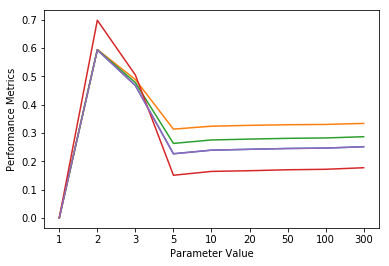

In [0]:
print_measures_and_plot_scores(r,svd_scores,'SVD')

In [0]:
# NMF
from sklearn.decomposition import NMF
nmf_scores = [[],[],[],[],[]]

for i in r:
    nmf = NMF(n_components = i, random_state=42)
    cluster_nmf = nmf.fit_transform(cluster_tfidf)
    k_mean.fit(cluster_nmf)
    nmf_scores[0].append(metrics.homogeneity_score(bi_cluster_dataset_target, k_mean.labels_))
    nmf_scores[1].append(metrics.completeness_score(bi_cluster_dataset_target, k_mean.labels_))
    nmf_scores[2].append(metrics.v_measure_score(bi_cluster_dataset_target, k_mean.labels_))
    nmf_scores[3].append(metrics.adjusted_rand_score(bi_cluster_dataset_target, k_mean.labels_))
    nmf_scores[4].append(metrics.adjusted_mutual_info_score(bi_cluster_dataset_target, k_mean.labels_))

E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_metho

Report for NMF Measures and Plot

Homogeneity:	[0.00062248, 0.64555736, 0.2358711, 0.18267641, 0.18882853, 0.09121973, 0.0023278, 0.0011893, 0.00052139]
Completeness:	[0.00062706, 0.64726116, 0.31873557, 0.27945555, 0.28669622, 0.19078409, 0.03334421, 0.01410889, 0.01300099]
V_measure:	[0.00062476, 0.64640814, 0.27111289, 0.22093229, 0.22769131, 0.1234258, 0.00435179, 0.00219368, 0.00100258]
Adj rand Idx:	[0.00078533, 0.74513836, 0.16370145, 0.10473047, 0.10854395, 0.03430315, -9.385e-05, -9.278e-05, -5.647e-05]
Adj Mut Info:	[0.00053098, 0.64552491, 0.23580113, 0.18260157, 0.18875425, 0.0911365, 0.00223577, 0.00109732, 0.00042851]

Best r value:	 2


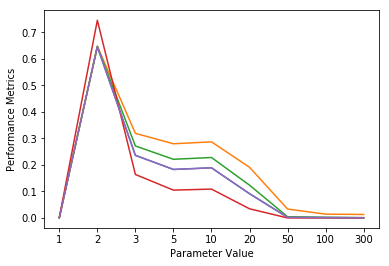

In [0]:
print_measures_and_plot_scores(r,nmf_scores,'NMF')

### Part 4. Visualization

#### Question 7: Visualize the clustering results

In [0]:
def visualize_2d(X, y, title=None, random_state=None,r=2,color_offset=0):
    """
    visualize data in 2d plane
    """
    colors = ['r', 'g', 'b', 'm', 'y', 'c']
    if r > 2:
        svd = TruncatedSVD(n_components = 2, n_iter = 7, random_state = 42)
        X_proj = svd.fit_transform(X)
    plt.figure()
    
    for i in range(2):
        points = np.array([X[j] for j in range(len(X)) if y[j] == i])
        plt.scatter(points[:,0], points[:,1], s=7, c=colors[i+color_offset], alpha=0.4)
    
    if title is not None:
        plt.title(title)

SVD with its best r

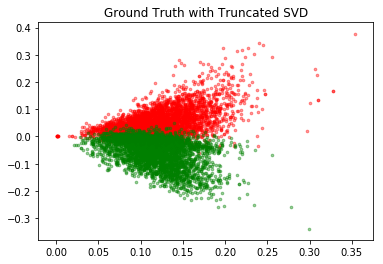

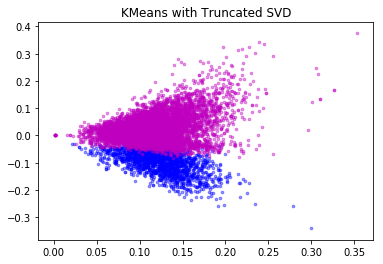

In [0]:
# SVD with best r=2
r = 2
k_mean.fit(cluster_svd)
visualize_2d(cluster_svd, bi_cluster_dataset_target,
             title="Ground Truth with Truncated SVD", random_state=42,r=r)
visualize_2d(cluster_svd, k_mean.labels_,
             title="KMeans with Truncated SVD", random_state=42,r=r,color_offset=2)

#metric_names, metric_vals = classification_result(kmeans.labels_, all_target)
#print("\n".join("{}: {}".format(name,val) for name,val in zip(metric_names,metric_vals)))

NMF with its best r

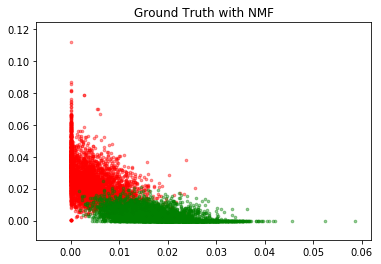

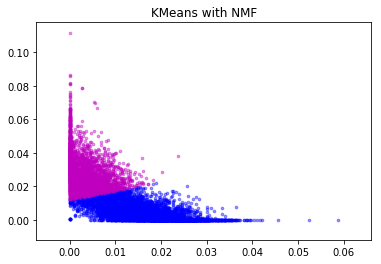

In [0]:
# NMF with best r=2
r = 2
nmf = NMF(n_components = r, init='random', random_state=0)
cluster_nmf = nmf.fit_transform(cluster_tfidf)
k_mean.fit(cluster_nmf)
visualize_2d(cluster_nmf, bi_cluster_dataset_target,
             title="Ground Truth with NMF", random_state=42,r=r)
visualize_2d(cluster_nmf, k_mean.labels_, title="KMeans with NMF",
             random_state=42,r=r,color_offset=2)

#### Question 8: Visualize the transformed data as in part (a)

In [0]:
def print_measures(target, labels, title):
    print(title)
    print('Homogeneity: %0.8f' % metrics.homogeneity_score(target, labels))
    print('Completeness: %0.8f' % metrics.completeness_score(target, labels))
    print('V-measure: %0.8f' % metrics.v_measure_score(target, labels))
    print('Adjusted Rand-Index: %0.8f' % metrics.adjusted_rand_score(target, labels))
    print('Adjusted Mutual Information Score: %0.8f' % metrics.adjusted_mutual_info_score(target, labels))
    print('')

Scaling Transformation - SVD

Report for Transformed SVD

Homogeneity: 0.00142197
Completeness: 0.00147693
V-measure: 0.00144893
Adjusted Rand-Index: 0.00193808
Adjusted Mutual Information Score: 0.00133055

Confusion matrix, without normalization


E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


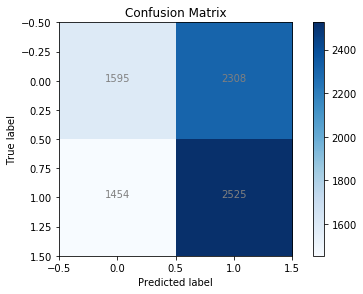

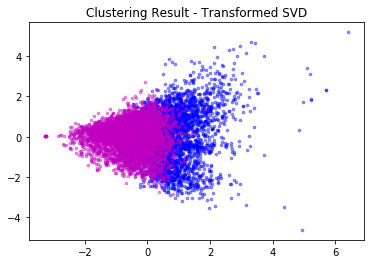

In [0]:
from sklearn import preprocessing
cluster_transformed_svd = preprocessing.scale(cluster_svd)
k_mean.fit(cluster_transformed_svd)

print_measures(bi_cluster_dataset_target, k_mean.labels_, 'Report for Transformed SVD\n')
plot_confusion_matrix(bi_cluster_dataset_target, k_mean.labels_)
visualize_2d(cluster_transformed_svd, k_mean.labels_,
             title='Clustering Result - Transformed SVD',
             random_state = 42,r = r,color_offset = 2)

Scaling Transformation - NMF

Report for Transformed NMF

Homogeneity: 0.65521002
Completeness: 0.65920609
V-measure: 0.65720198
Adjusted Rand-Index: 0.74513840
Adjusted Mutual Information Score: 0.65517846

Confusion matrix, without normalization


E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


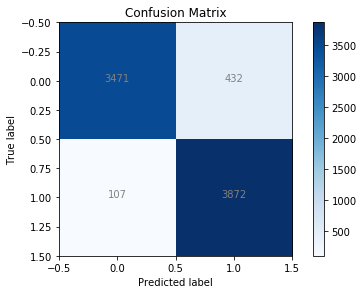

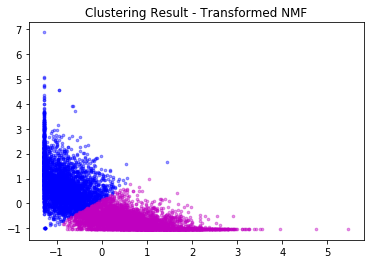

In [0]:
cluster_transformed_nmf = preprocessing.scale(cluster_nmf)
k_mean.fit(cluster_transformed_nmf)

print_measures(bi_cluster_dataset_target, k_mean.labels_, 'Report for Transformed NMF\n')
plot_confusion_matrix(bi_cluster_dataset_target, k_mean.labels_)
visualize_2d(cluster_transformed_nmf, k_mean.labels_,
             title = 'Clustering Result - Transformed NMF',
             random_state = 42, r = r, color_offset = 2)

#### Question 10: Logarithm Transformation

In [0]:
c = 0.01

Logarithm Transformation - SVD

Report for Logarithm Transformed SVD - Log

Homogeneity: 0.70752341
Completeness: 0.70786661
V-measure: 0.70769497
Adjusted Rand-Index: 0.80409396
Adjusted Mutual Information Score: 0.70749664



E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


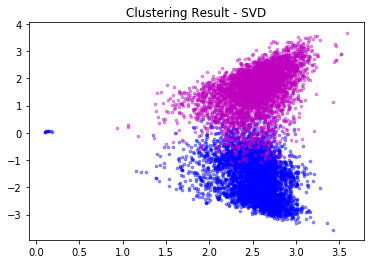

In [0]:
cluster_transformed_svd_log = np.sign(cluster_svd)*(np.log(abs(cluster_svd) + c)-np.log(c))
k_mean.fit(cluster_transformed_svd_log)

print_measures(bi_cluster_dataset_target, k_mean.labels_, 'Report for Logarithm Transformed SVD - Log\n')
visualize_2d(cluster_transformed_svd_log, k_mean.labels_,
             title="Clustering Result - SVD",
             random_state = 42, r = r, color_offset = 2)

Logarithm Transformation - NMF

Report for Transformed NMF - Log

Homogeneity: 0.67759508
Completeness: 0.67965230
V-measure: 0.67862213
Adjusted Rand-Index: 0.77210412
Adjusted Mutual Information Score: 0.67756557



E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


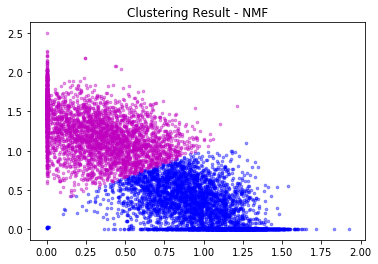

In [0]:
cluster_transformed_nmf_log = np.sign(cluster_nmf)*(np.log(abs(cluster_nmf) + c)-np.log(c))
k_mean.fit(cluster_transformed_nmf_log)

print_measures(bi_cluster_dataset_target, k_mean.labels_, 'Report for Transformed NMF - Log\n')
visualize_2d(cluster_transformed_nmf_log, k_mean.labels_,
             title="Clustering Result - NMF",
             random_state = 42, r = r, color_offset = 2)

Logarithm & Scaling Transformation - SVD

Report for Logarithm & Scaling Transformed - SVD

Homogeneity: 0.00271395
Completeness: 0.00271665
V-measure: 0.00271530
Adjusted Rand-Index: 0.00358223
Adjusted Mutual Information Score: 0.00262265



E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


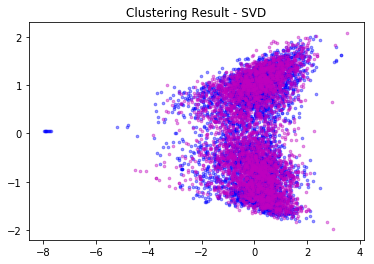

In [0]:
cluster_log_transformed_svd_LS = np.sign(cluster_svd)*(np.log(abs(cluster_svd) + c)-np.log(c))
cluster_log_transformed_svd_LS = preprocessing.scale(cluster_log_transformed_svd_LS)
k_mean.fit(cluster_log_transformed_svd_LS)

print_measures(bi_cluster_dataset_target, k_mean.labels_, 'Report for Logarithm & Scaling Transformed - SVD\n')
visualize_2d(cluster_log_transformed_svd_LS, k_mean.labels_,
             title = 'Clustering Result - SVD',
             random_state = 42,r = r,color_offset = 2)

Logarithm & Scaling Transformation - NMF

Report for Logarithm & Scaling Transformed - NMF

Homogeneity: 0.66692234
Completeness: 0.66911136
V-measure: 0.66801505
Adjusted Rand-Index: 0.76232352
Adjusted Mutual Information Score: 0.66689184



E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


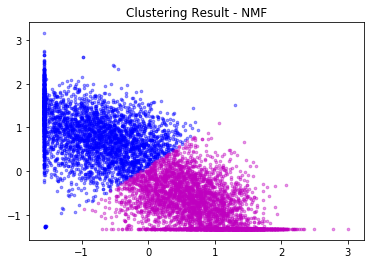

In [0]:
cluster_log_transformed_nmf_LS = np.sign(cluster_nmf)*(np.log(abs(cluster_nmf) + c)-np.log(c))
cluster_log_transformed_nmf_LS = preprocessing.scale(cluster_log_transformed_nmf_LS)
k_mean.fit(cluster_log_transformed_nmf_LS)

print_measures(bi_cluster_dataset_target, k_mean.labels_, 'Report for Logarithm & Scaling Transformed - NMF\n')
visualize_2d(cluster_log_transformed_nmf_LS, k_mean.labels_,
             title = 'Clustering Result - NMF',
             random_state=42,r=r,color_offset=2)

Scaling & Logarithm Transformation - SVD

Report for Scaling & Logarithm Transformed - SVD

Homogeneity: 0.01219429
Completeness: 0.01226496
V-measure: 0.01222952
Adjusted Rand-Index: 0.01681976
Adjusted Mutual Information Score: 0.01210386



E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


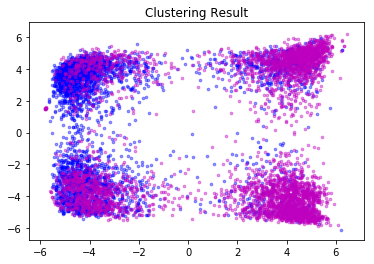

In [0]:
cluster_log_transformed_svd_SL = preprocessing.scale(cluster_svd)
cluster_log_transformed_svd_SL = np.sign(cluster_log_transformed_svd_SL)*(np.log(abs(cluster_log_transformed_svd_SL) + c)-np.log(c))
k_mean.fit(cluster_log_transformed_svd_SL)

print_measures(bi_cluster_dataset_target, k_mean.labels_, 'Report for Scaling & Logarithm Transformed - SVD\n')
visualize_2d(cluster_log_transformed_svd_SL, k_mean.labels_,
             title="Clustering Result",
             random_state=42,r=r,color_offset=2)

Scaling & Logarithm Transformation - NMF

Report for Scaling & Logarithm Transformed - NMF

Homogeneity: 0.58796070
Completeness: 0.58871170
V-measure: 0.58833596
Adjusted Rand-Index: 0.69137780
Adjusted Mutual Information Score: 0.58792298



E:\anaconda\envs\UCLA\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


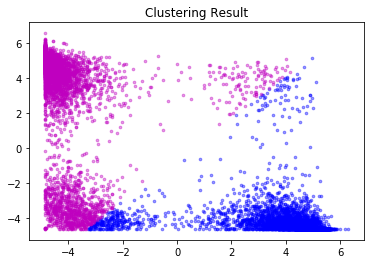

In [0]:
cluster_log_transformed_nmf_SL = preprocessing.scale(cluster_nmf)
cluster_log_transformed_nmf_SL = np.sign(cluster_log_transformed_nmf_SL)*(np.log(abs(cluster_log_transformed_nmf_SL) + c)-np.log(c))
k_mean.fit(cluster_log_transformed_nmf_SL)

print_measures(bi_cluster_dataset_target, k_mean.labels_, 'Report for Scaling & Logarithm Transformed - NMF\n')
visualize_2d(cluster_log_transformed_nmf_SL, k_mean.labels_,
             title="Clustering Result",
             random_state=42,r=r,color_offset=2)

### Part 5: Expand Dataset into 20 Categories (Start Run Here)

In [0]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from matplotlib import mlab as mlab

import numpy as np
np.random.seed(42)
import random
random.seed(42)

nltk.download('stopwords')

# Defined stopwords
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords

stop_words_en = stopwords.words('english')

from string import punctuation
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

from sklearn.cluster import KMeans
from sklearn import metrics
from matplotlib.cm import get_cmap
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def plot_confusion_matrix_20(target, labels):
    """
    This function geives credit to : website
    "http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html"
    """
    cm = metrics.confusion_matrix(target, labels)

    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
 

In [0]:
def print_measures_20(target, labels, title):
    print(title)
    print('Homogeneity: %0.8f' % metrics.homogeneity_score(target, labels))
    print('Completeness: %0.8f' % metrics.completeness_score(target, labels))
    print('V-measure: %0.8f' % metrics.v_measure_score(target, labels))
    print('Adjusted Rand-Index: %0.8f' % metrics.adjusted_rand_score(target, labels))
    print('Adjusted Mutual Information Score: %0.8f' % metrics.adjusted_mutual_info_score(target, labels))
    print(' ')

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()
def stem_rmv_punc(doc):
    return (word for word in analyzer(doc) if word.isalpha() and word not in combined_stopwords)

#### Question 11: Repeat for 20 Categories

In [0]:
cluster_dataset20 = fetch_20newsgroups(subset='all', shuffle = True, random_state = 42)

count_vectorizer20 = CountVectorizer(min_df = 3, max_df = 0.9, stop_words = 'english',analyzer = stem_rmv_punc)

cluster_counts20 = count_vectorizer20.fit_transform(cluster_dataset20.data)

tfidf_transformer = TfidfTransformer(norm = 'l2', sublinear_tf=False)

cluster_tfidf20 = tfidf_transformer.fit_transform(cluster_counts20)

print ('Dimension of TF-IDF Matrix: ', cluster_tfidf20.shape)

Dimension of TF-IDF Matrix:  (18846, 42963)


In [0]:
true_k = 20
k_mean = KMeans(n_clusters = true_k, n_jobs=-1, random_state = 0, max_iter = 1000, n_init = 30)
k_mean.fit(cluster_tfidf20)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=20, n_init=30, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

Reprot for 20 categories

Homogeneity: 0.30727299
Completeness: 0.36882700
V-measure: 0.33524797
Adjusted Rand-Index: 0.12350912
Adjusted Mutual Information Score: 0.30501677
 


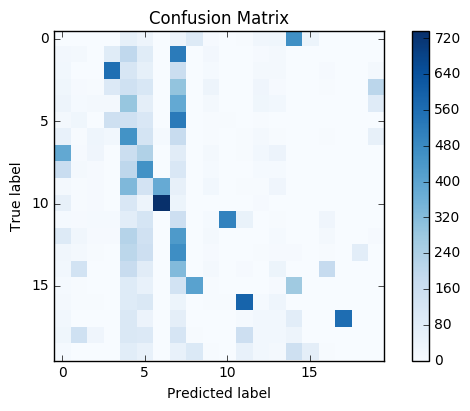

In [0]:
print_measures_20(cluster_dataset20.target, k_mean.labels_, 'Reprot for 20 categories\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

#### Question 12: Different Dimensions

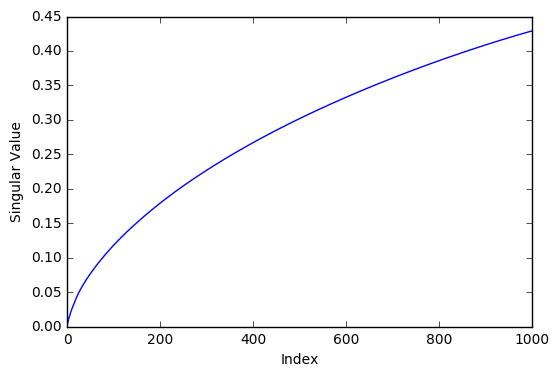

In [0]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 1000, random_state = 42)
cluster_svd20 = svd.fit_transform(cluster_tfidf20)

var_retained20 = np.cumsum(svd.explained_variance_ratio_)

plt.plot(var_retained20)
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.show()

In [0]:
def print_measures_and_plot_scores_20( r_value,scores,title):
    
    # Get best r
    best_r = r_value[np.argmax(np.sum(scores,axis=0))]
    indexMax = np.argmax(np.sum(scores,axis=0))
    
    # Formating measures and print out
    homogeneity = round(scores[0][indexMax],8)
    completeness = round(scores[1][indexMax],8)
    v_measure = round(scores[2][indexMax],8)
    adjusted_rand = round(scores[3][indexMax],8)
    adjusted_mutual_info= round(scores[4][indexMax],8)
     
    print('Report for {} Measures and Plot'.format(title))
    print('\nBest Homogeneity:\t{}\nBest Completeness:\t{}\nBest V_measure:\t\t{}\nBest Adj rand Idx:\t{}\nBest Adj Mut Info:\t{}'.format(
        homogeneity,completeness,v_measure,adjusted_rand,adjusted_mutual_info))
    print('\nBest r value: ',best_r)
    
    
    # plot
    legend = ['Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand', 'Adjusted Mutual Info']
    x_new = [str(i) for i in r_value]
    for i in range(5):
        plt.plot(x_new,scores[i],label=legend[i])
    plt.ylabel('Performance Metrics')
    plt.xlabel('Parameter Value')
    plt.show()

 

Truncated - SVD

In [0]:
# Truncated SVD 
r = list(range(1, 200, 2))
svd_scores = [[],[],[],[],[]]
for i in r:
    # Reduce dimension to r
    k_mean.fit(cluster_svd20[:,:i])
    svd_scores[0].append(metrics.homogeneity_score(cluster_dataset20.target, k_mean.labels_))
    svd_scores[1].append(metrics.completeness_score(cluster_dataset20.target, k_mean.labels_))
    svd_scores[2].append(metrics.v_measure_score(cluster_dataset20.target, k_mean.labels_))
    svd_scores[3].append(metrics.adjusted_rand_score(cluster_dataset20.target, k_mean.labels_))
    svd_scores[4].append(metrics.adjusted_mutual_info_score(cluster_dataset20.target, k_mean.labels_))

Report for SVD Measures and Plot

Best Homogeneity:	0.33767113
Best Completeness:	0.50211484
Best V_measure:		0.40379261
Best Adj rand Idx:	0.08443825
Best Adj Mut Info:	0.33549393

Best r value:  101


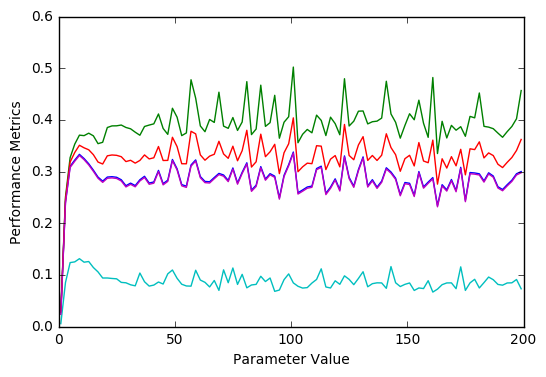

In [0]:
print_measures_and_plot_scores_20(r, svd_scores, 'SVD')

Truncated - NMF

In [0]:
from sklearn.decomposition import NMF
r2 = list(range(1, 60, 4))
nmf_scores = [[],[],[],[],[]]
for i in r2:
    nmf = NMF(n_components = i, random_state = 42)
    cluster_nmf20 = nmf.fit_transform(cluster_tfidf20)
    k_mean.fit(cluster_nmf20)
    nmf_scores[0].append(metrics.homogeneity_score(cluster_dataset20.target, k_mean.labels_))
    nmf_scores[1].append(metrics.completeness_score(cluster_dataset20.target, k_mean.labels_))
    nmf_scores[2].append(metrics.v_measure_score(cluster_dataset20.target, k_mean.labels_))
    nmf_scores[3].append(metrics.adjusted_rand_score(cluster_dataset20.target, k_mean.labels_))
    nmf_scores[4].append(metrics.adjusted_mutual_info_score(cluster_dataset20.target, k_mean.labels_))

Report for NMF Measures and Plot

Best Homogeneity:	0.31450968
Best Completeness:	0.34207163
Best V_measure:		0.32771216
Best Adj rand Idx:	0.11812113
Best Adj Mut Info:	0.31229137

Best r value:  9


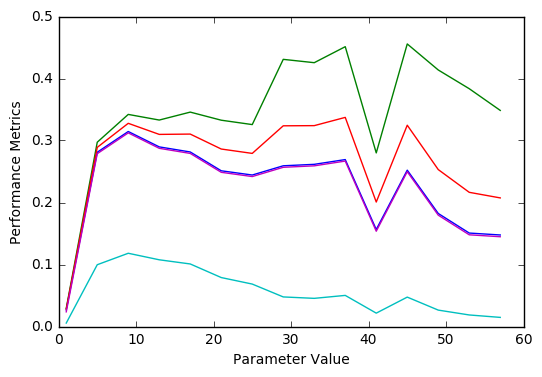

In [0]:
print_measures_and_plot_scores_20(r2, nmf_scores, 'NMF')

Visualized Best r - SVD

In [0]:
def visualize_2d20(X, y, title=None, random_state=None,r=2,color_offset=0):
    """
    visualize data in 2d plane
    """
    colors = ['r', 'g', 'b', 'm', 'y', 'c','r', 'g', 'b', 'm', 'y', 'c','r', 'g', 'b', 'm', 'y', 'c','r', 'g']
    if r > 2:
        svd = TruncatedSVD(n_components = 2, n_iter = 7, random_state = 42)
        X_proj = svd.fit_transform(X)
    plt.figure()
    
    for i in range(20):
        points = np.array([X[j] for j in range(len(X)) if y[j] == i])
        plt.scatter(points[:,0], points[:,1], s=7, c=colors[i+color_offset], alpha=0.4)
    
    if title is not None:
        plt.title(title)

In [0]:
# Best of r value found previously
r_SVD = 101
r_NMF = 9

Reprot for 20 categories - Truncated SVD

Homogeneity: 0.33767113
Completeness: 0.50211484
V-measure: 0.40379261
Adjusted Rand-Index: 0.08443825
Adjusted Mutual Information Score: 0.33549393
 


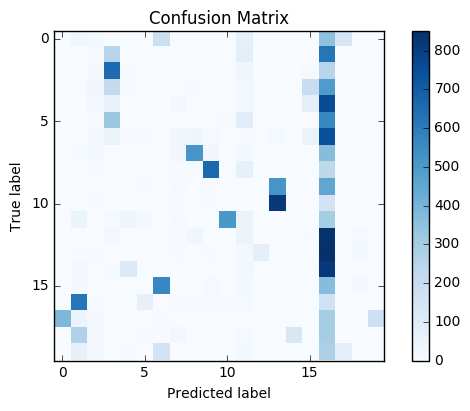

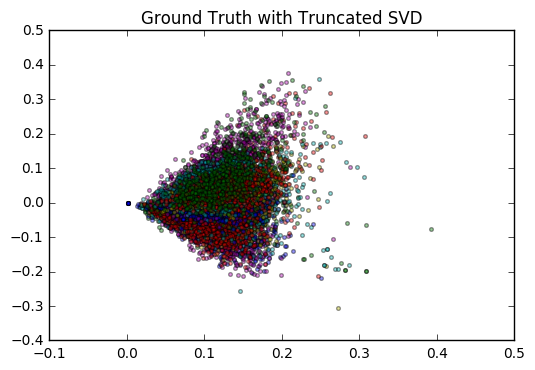

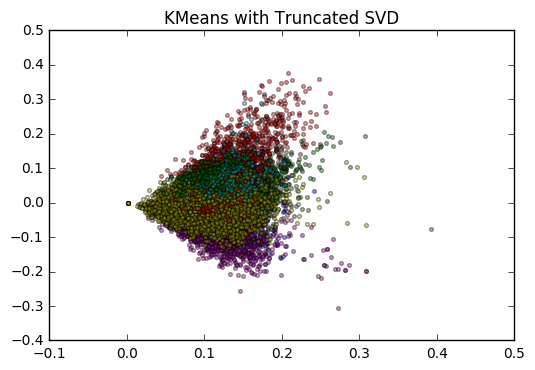

In [0]:
# SVD with best r = 101
#svd = TruncatedSVD(n_components = r_SVD, random_state = 42)
#cluster_svd20 = svd.fit_transform(cluster_tfidf20)
cluster_svd20 = cluster_svd20[:,:r_SVD]

k_mean.fit(cluster_svd20)

print_measures_20(cluster_dataset20.target, k_mean.labels_, 'Reprot for 20 categories - Truncated SVD\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_svd20, cluster_dataset20.target,
             title="Ground Truth with Truncated SVD",
             random_state = 42, r = r_SVD)
visualize_2d20(cluster_svd20, k_mean.labels_,
             title="KMeans with Truncated SVD",
             random_state = 42, r = r_SVD, color_offset = 0)

Visualized Best r - NMF

Reprot for 20 categories - Truncated NMF

Homogeneity: 0.31450968
Completeness: 0.34207163
V-measure: 0.32771216
Adjusted Rand-Index: 0.11812113
Adjusted Mutual Information Score: 0.31229137
 


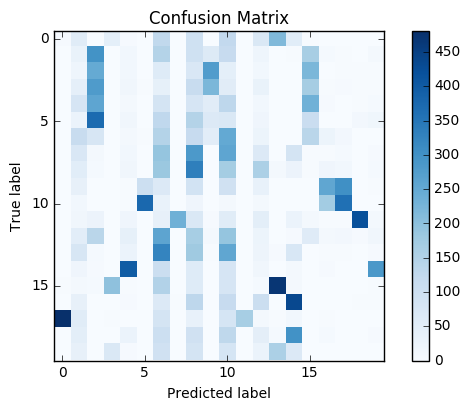

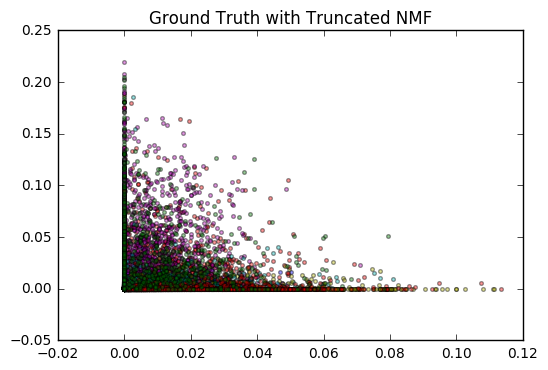

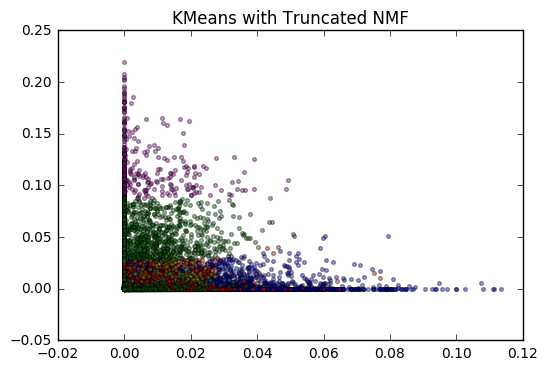

In [0]:
# NMF with best r = 9
nmf = NMF(n_components = r_NMF, random_state=42)
cluster_nmf20 = nmf.fit_transform(cluster_tfidf20)
k_mean.fit(cluster_nmf20)

print_measures_20(cluster_dataset20.target, k_mean.labels_, 'Reprot for 20 categories - Truncated NMF\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_nmf20, cluster_dataset20.target,
             title="Ground Truth with Truncated NMF",
             random_state = 42,r = r_NMF)
visualize_2d20(cluster_nmf20, k_mean.labels_,
             title="KMeans with Truncated NMF",
             random_state=42, r = r_NMF, color_offset = 0)

Scaling Transformation - SVD

Reprot for 20 categories - Scaling Transformation - SVD

Homogeneity: 0.24503944
Completeness: 0.38762340
V-measure: 0.30026426
Adjusted Rand-Index: 0.06158757
Adjusted Mutual Information Score: 0.24252562
 


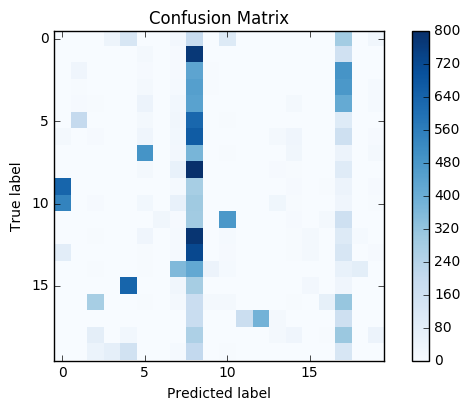

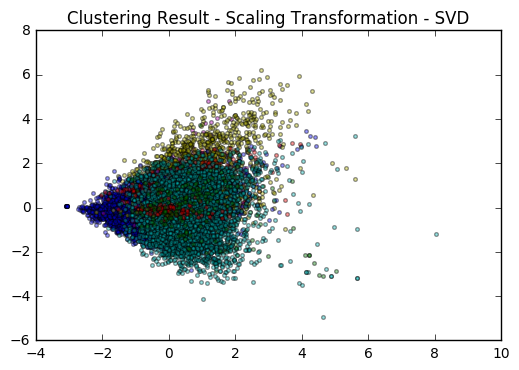

In [0]:
from sklearn import preprocessing
cluster_transformed_svd_20 = preprocessing.scale(cluster_svd20)
k_mean.fit(cluster_transformed_svd_20)

print_measures_20(cluster_dataset20.target, k_mean.labels_, 'Reprot for 20 categories - Scaling Transformation - SVD\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_transformed_svd_20, k_mean.labels_,
             title="Clustering Result - Scaling Transformation - SVD",
             random_state = 42,r = r_SVD, color_offset = 0)

Scaling Transformation - NMF

Reprot for 20 categories - Scaling Transformation - NMF

Homogeneity: 0.30743790
Completeness: 0.33469014
V-measure: 0.32048572
Adjusted Rand-Index: 0.11888527
Adjusted Mutual Information Score: 0.30519662
 


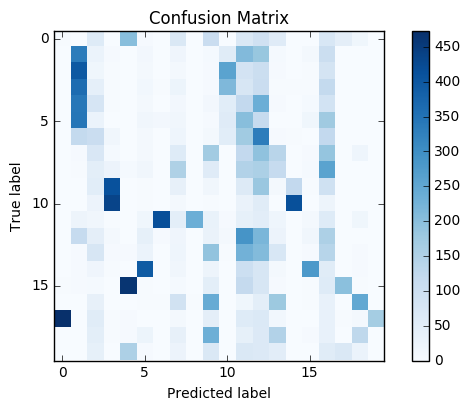

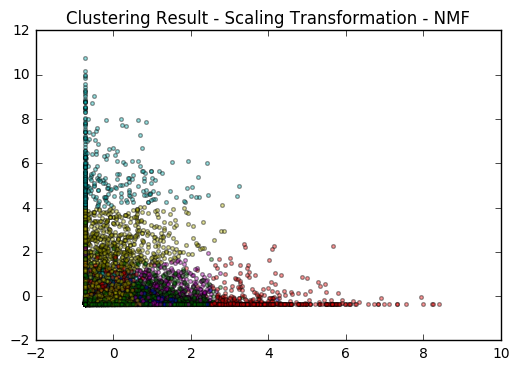

In [0]:
cluster_transformed_nmf_20 = preprocessing.scale(cluster_nmf20)
k_mean.fit(cluster_transformed_nmf_20)

print_measures_20(cluster_dataset20.target, k_mean.labels_, 'Reprot for 20 categories - Scaling Transformation - NMF\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_transformed_nmf_20, k_mean.labels_,
             title="Clustering Result - Scaling Transformation - NMF",
             random_state = 42, r = r_NMF, color_offset = 0)

Logarithm Transformation - SVD

In [0]:
c = 0.01

Reprot for 20 categories - Logarithm Transformation - SVD

Homogeneity: 0.35444207
Completeness: 0.37708421
V-measure: 0.36541273
Adjusted Rand-Index: 0.18471945
Adjusted Mutual Information Score: 0.35235589
 


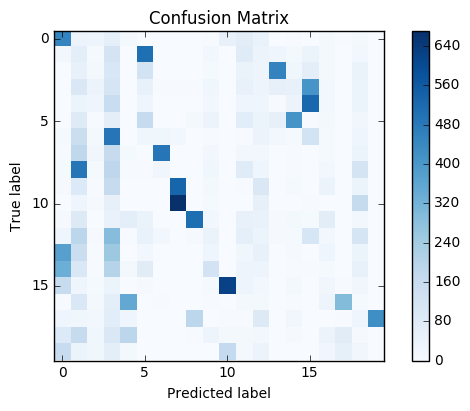

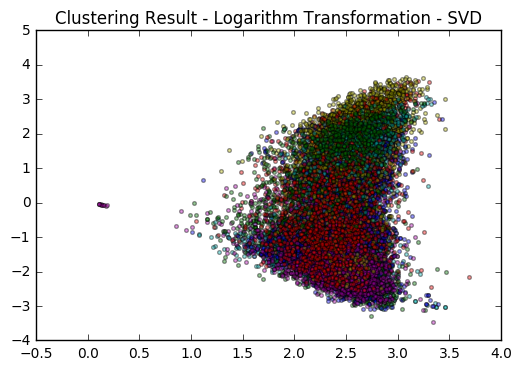

In [0]:
cluster_log_transformed_svd_20 = np.sign(cluster_svd20)*(np.log(abs(cluster_svd20) + c)-np.log(c))
k_mean.fit(cluster_log_transformed_svd_20)

print_measures_20(cluster_dataset20.target, k_mean.labels_,
                  'Reprot for 20 categories - Logarithm Transformation - SVD\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_log_transformed_svd_20, k_mean.labels_,
             title="Clustering Result - Logarithm Transformation - SVD",
             random_state = 42, r = r_SVD, color_offset = 0)

Logarithm Transformation - NMF

Reprot for 20 categories - Logarithm Transformation - NMF

Homogeneity: 0.36826352
Completeness: 0.37809277
V-measure: 0.37311342
Adjusted Rand-Index: 0.17616184
Adjusted Mutual Information Score: 0.36622365
 


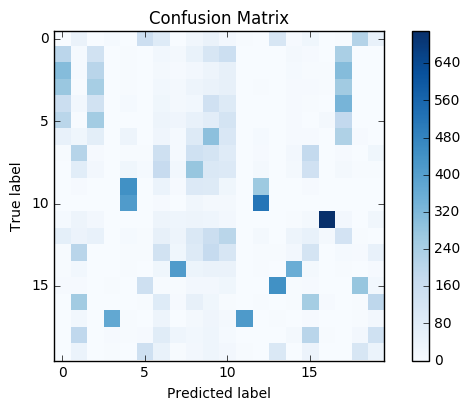

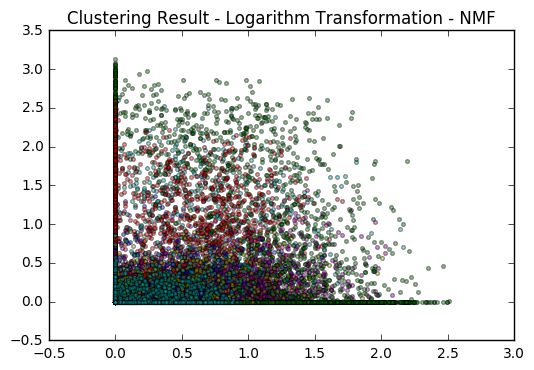

In [0]:
cluster_log_transformed_nmf_20 = np.sign(cluster_nmf20)*(np.log(abs(cluster_nmf20) + c)-np.log(c))
k_mean.fit(cluster_log_transformed_nmf_20)

print_measures_20(cluster_dataset20.target, k_mean.labels_,
                  'Reprot for 20 categories - Logarithm Transformation - NMF\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_log_transformed_nmf_20, k_mean.labels_,
             title="Clustering Result - Logarithm Transformation - NMF",
             random_state = 42, r = r_NMF, color_offset = 0)

Logarithm & Scaling Transformation - SVD

Reprot for 20 categories - Logarithm & Scaling Transformation - SVD

Homogeneity: 0.37387140
Completeness: 0.41890377
V-measure: 0.39510859
Adjusted Rand-Index: 0.19166662
Adjusted Mutual Information Score: 0.37184460
 


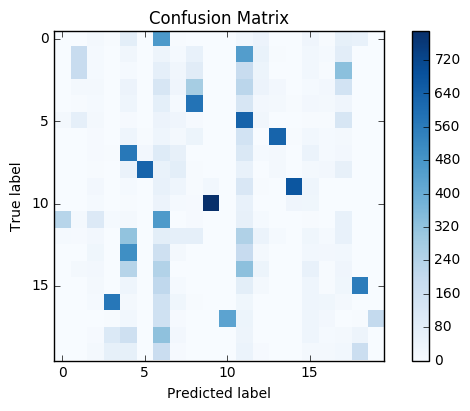

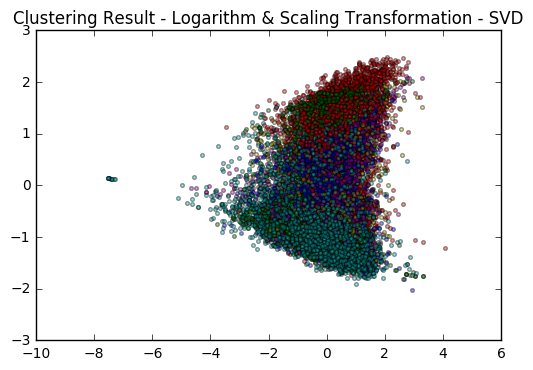

In [0]:
cluster_log_transformed_svd_20_LS = np.sign(cluster_svd20)*(np.log(abs(cluster_svd20) + c)-np.log(c))
cluster_log_transformed_svd_20_LS = preprocessing.scale(cluster_log_transformed_svd_20_LS)
k_mean.fit(cluster_log_transformed_svd_20_LS)

print_measures_20(cluster_dataset20.target, k_mean.labels_,
                  'Reprot for 20 categories - Logarithm & Scaling Transformation - SVD\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_log_transformed_svd_20_LS, k_mean.labels_,
             title="Clustering Result - Logarithm & Scaling Transformation - SVD",
             random_state = 42, r = r_SVD, color_offset = 0)

Logarithm & Scaling Transformation - NMF

Reprot for 20 categories - Logarithm & Scaling Transformation - NMF

Homogeneity: 0.37482996
Completeness: 0.38324163
V-measure: 0.37898913
Adjusted Rand-Index: 0.18567764
Adjusted Mutual Information Score: 0.37281158
 


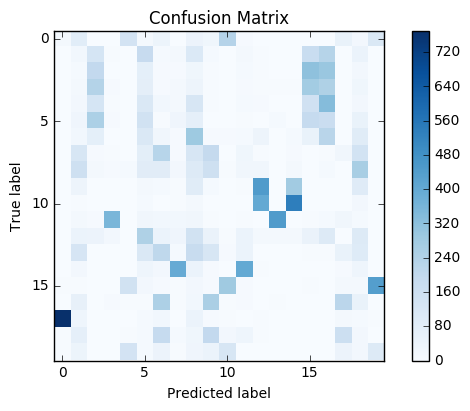

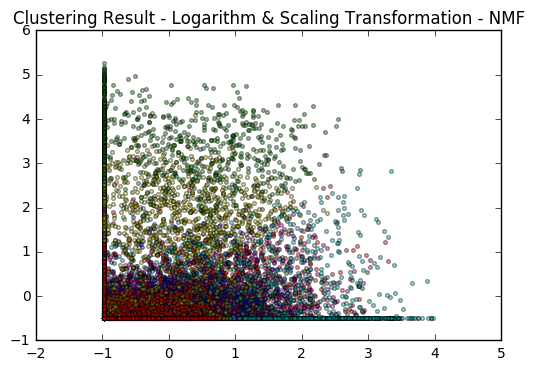

In [0]:
cluster_log_transformed_nmf_20_LS = np.sign(cluster_nmf20)*(np.log(abs(cluster_nmf20) + c)-np.log(c))
cluster_log_transformed_nmf_20_LS = preprocessing.scale(cluster_log_transformed_nmf_20_LS)
k_mean.fit(cluster_log_transformed_nmf_20_LS)

print_measures_20(cluster_dataset20.target, k_mean.labels_,
                  'Reprot for 20 categories - Logarithm & Scaling Transformation - NMF\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_log_transformed_nmf_20_LS, k_mean.labels_,
             title="Clustering Result - Logarithm & Scaling Transformation - NMF",
             random_state = 42, r = r_NMF, color_offset = 0)

Scaling & Logarithm Transformation - SVD

Reprot for 20 categories - Scaling & Logarithm Transformation - SVD

Homogeneity: 0.41883125
Completeness: 0.44031659
V-measure: 0.42930527
Adjusted Rand-Index: 0.23054827
Adjusted Mutual Information Score: 0.41695379
 


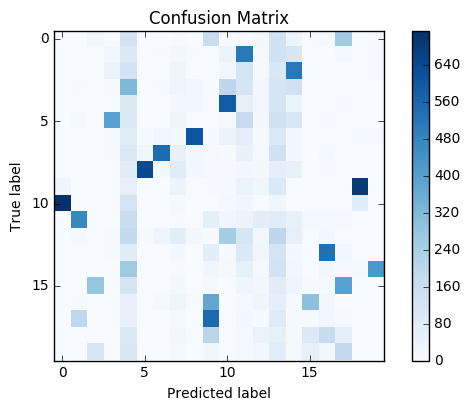

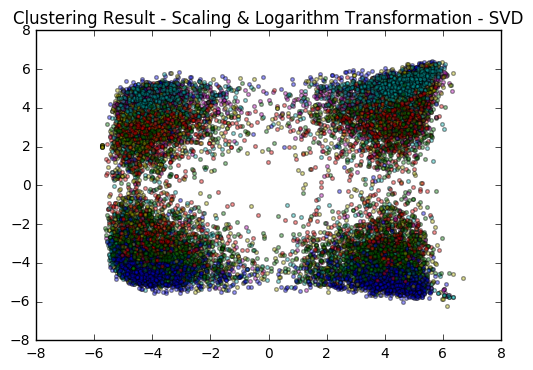

In [0]:
cluster_log_transformed_svd_20_SL = preprocessing.scale(cluster_svd20)
cluster_log_transformed_svd_20_SL = np.sign(cluster_log_transformed_svd_20_SL)*(np.log(abs(cluster_log_transformed_svd_20_SL) + c)-np.log(c))
k_mean.fit(cluster_log_transformed_svd_20_SL)

print_measures_20(cluster_dataset20.target, k_mean.labels_,
                  'Reprot for 20 categories - Scaling & Logarithm Transformation - SVD\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_log_transformed_svd_20_SL, k_mean.labels_,
             title="Clustering Result - Scaling & Logarithm Transformation - SVD",
             random_state = 42, r = r_SVD, color_offset = 0)

Scaling & Logarithm Transformation - NMF

Reprot for 20 categories - Scaling & Logarithm Transformation - NMF

Homogeneity: 0.33737905
Completeness: 0.34665433
V-measure: 0.34195381
Adjusted Rand-Index: 0.16145134
Adjusted Mutual Information Score: 0.33523967
 


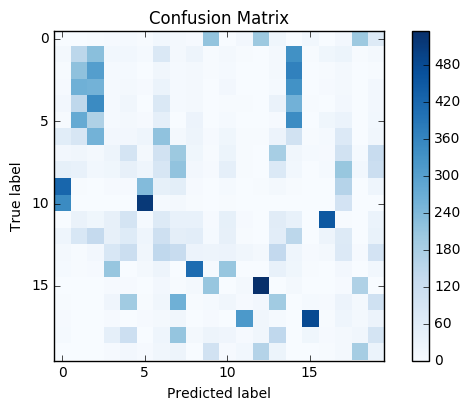

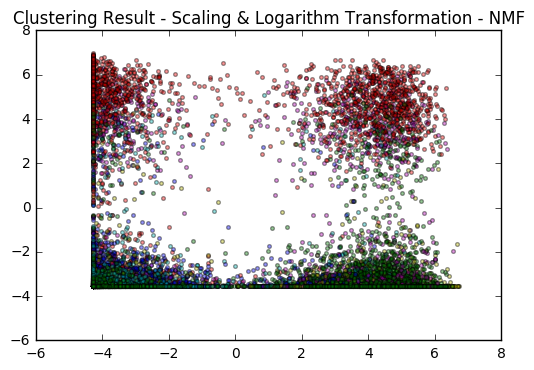

In [0]:
cluster_log_transformed_nmf_20_SL = preprocessing.scale(cluster_nmf20)
cluster_log_transformed_nmf_20_SL = np.sign(cluster_log_transformed_nmf_20_SL)*(np.log(abs(cluster_log_transformed_nmf_20_SL) + c)-np.log(c))
k_mean.fit(cluster_log_transformed_nmf_20_SL)

print_measures_20(cluster_dataset20.target, k_mean.labels_,
                  'Reprot for 20 categories - Scaling & Logarithm Transformation - NMF\n')
plot_confusion_matrix_20(cluster_dataset20.target, k_mean.labels_)

visualize_2d20(cluster_log_transformed_nmf_20_SL, k_mean.labels_,
             title="Clustering Result - Scaling & Logarithm Transformation - NMF",
             random_state = 42, r = r_NMF, color_offset = 0)